# Applications of BrainNetCNN 
## Summary :
This notebook uses the brainnetCNN described [here](https://github.com/AmineEch/BrainCNN/blob/master/BrainNetCNN.ipynb) to execute various predictions on data collected from nilearn database, than we compare the performance of BrainNetCNN against other methods (such as svms) known to preform desently on these sets of data.


In [4]:
from __future__ import print_function, division

import matplotlib.pyplot as plt
plt.interactive(False)
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import optimizers, callbacks, regularizers, initializers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from E2E_conv import *
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure
from sklearn.cross_validation import StratifiedKFold
from keras.utils import to_categorical

Using TensorFlow backend.
/usr/bin/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Fetching datasets and constructing the training and test data :
We compute region signals and extract useful phenotypic informations, We use 'tangent' connectivity kind to construct the connectomes. (for more information click [here](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py)


In [5]:
adhd_data = datasets.fetch_adhd(n_subjects=20)
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

conn_measure = ConnectivityMeasure(kind="tangent")
X = conn_measure.fit_transform(pooled_subjects)
Y = np.array(adhd_labels,dtype="float32")


## Setting up the network archticeture
Unlike the BrainNetCNN used to predict cognitive and motor score described [here](https://github.com/AmineEch/BrainCNN/blob/master/BrainNetCNN.ipynb), we opt for a less deeper network architecture considering the limited size of data to prevent overfitting, therefore we use one E2E layer instead of 2, with less units.

In [3]:
# Hyper parameters

batch_size = 14
dropout = 0.5
momentum = 0.9
lr = 0.001
decay = 0.0005

reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

# Model architecture

model = Sequential()
model.add(E2E_conv(2,8,(2,39),kernel_regularizer=reg,input_shape=(39,39,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(32,(1,39),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(90,(39,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(64,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(10,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,activation = "softmax",kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.summary()
#print(model.output_shape)


opt = optimizers.SGD(nesterov=True,lr=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
csv_logger = callbacks.CSVLogger('predict_age.log')

kernel_shape : (2, 39, 1, 8)
data shape : (?, 39, 39, 1)
(1, 39, 1, 8)
(39, 1, 1, 8)
cat1(?, 39, 39, 8)
cat2<dtype: 'float32'>
First layer output shape :(None, 39, 39, 8)
(None, 39, 39, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 39, 39, 8)         624       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 1, 32)         10016     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 39, 1, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)  

### Creating the training and test sets

In [5]:
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.33,random_state=42)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)


## Training and predicting

Train or predict ? [t/p]p
[*] Predicting and printing results for the models trained :


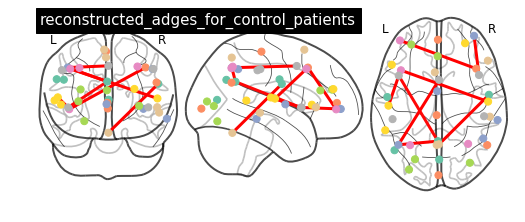

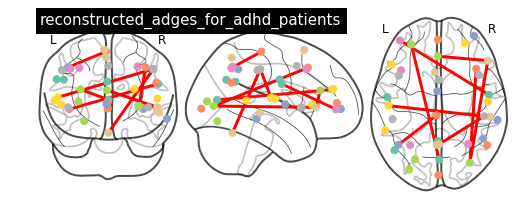

In [8]:
command = str(raw_input("Train or predict ? [t/p]"))
from vis.visualization import visualize_activation
from nilearn import plotting
if command == "t":
    print("Training the model ...")
    history=model.fit(x_train,y_train,batch_size=1,nb_epoch=1000,verbose=1,callbacks=[csv_logger])
    model.save_weights("Weights/BrainCNNWeights_categ.h5")
else:
    print("[*] Predicting and printing results for the models trained :")
    model.load_weights("Weights/BrainCNNWeights_categ.h5")
    list1 = []
    list0 = []
    for xcurp in x_test:
        heatmap1 = visualize_activation(model,layer_idx=-1, filter_indices=1, seed_input=xcurp,input_range = (0.,1.))[:,:,0]
        heatmap0 = visualize_activation(model,layer_idx=-1, filter_indices=0, seed_input=xcurp,input_range = (0.,1.))[:,:,0]
        list1.append(heatmap1.T+heatmap1)
        list0.append(heatmap0.T+heatmap0)
    list1 = np.stack(list1,axis=1)
    list0 = np.stack(list0,axis=1)
    mean_connectome_0 = list0.mean(axis=1)
    mean_connectome_1 = list1.mean(axis=1)
    %matplotlib inline
    plotting.plot_connectome(mean_connectome_0,msdl_coords,title="reconstructed_adges_for_control_patients",edge_threshold = '99%')
    plotting.plot_connectome(mean_connectome_1,msdl_coords,title="reconstructed_adges_for_adhd_patients",edge_threshold = '99%')

The BrainNetCNN does out preform the svm methode used [here](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py) by a margin of approximatly 10% accuracy.


## Using cross validation on adhd dataset
### BrainCNN 

In [ ]:
skf = StratifiedKFold(y_train, n_folds=4, shuffle=True)
accuracyBCNN = np.array([])
for i, (train, test) in enumerate(skf):
    history = model.fit(x_train[train], y_train[train], batch_size=1, nb_epoch=1000, verbose=0, callbacks=[csv_logger])
    y_pred = model.predict(x_train[test])
    accuracyBCNN = np.append(accuracy,np.array([accuracy_score(y_train[test], y_pred) * 100]))
    print('Accuracy : ' + str("{0:.2f}".format(accuracy_score(y_train[test], y_pred) * 100)) + " %")

print("mean accuracy :" + str(np.mean(accuracy)))

### SVM

In [1]:
accuracyBCNN = np.array([])
for i, (train, test) in enumerate(skf):
    history = model.fit(x_train[train], y_train[train], batch_size=1, nb_epoch=1000, verbose=0, callbacks=[csv_logger])
    y_pred = model.predict(x_train[test])
    accuracyBCNN = np.append(accuracy,np.array([accuracy_score(y_train[test], y_pred) * 100]))
    print('Accuracy : ' + str("{0:.2f}".format(accuracy_score(y_train[test], y_pred) * 100)) + " %")

NameError: name 'np' is not defined

In [6]:
print(msdl_coords)

[(-53.28, -8.88, 32.36), (53.47, -6.49, 27.52), (1.18, -74.54, 10.79), (-45.8, -64.78, 31.84), (-0.2, -55.21, 29.87), (-0.15, 51.42, 7.58), (51.66, -59.34, 28.88), (0.41, -91.05, 1.58), (-1.48, -27.93, 61.5), (40.1, 20.96, 44.72), (37.83, 55.49, 1.22), (47.53, -52.42, 43.06), (62.53, -32.99, -9.14), (-0.91, -2.75, 6.15), (-41.66, -59.04, 44.61), (-39.04, 19.28, 43.27), (-40.08, 50.65, 0.81), (-29.39, -59.43, 44.2), (31.6, -58.09, 45.69), (-30.54, -85.14, 9.1), (-24.29, -74.28, -11.74), (33.4, -77.96, 4.31), (-28.17, 46.32, 21.56), (-0.45, 34.06, 20.73), (28.38, 47.72, 22.13), (-52.12, -17.92, 13.28), (52.61, -13.65, 12.11), (-55.52, -43.77, 10.08), (-48.66, 25.11, 5.7), (-3.39, 17.19, 63.52), (54.42, -29.5, -2.72), (52.38, 29.39, 2.93), (1.05, -58.49, -23.91), (-1.44, -59.12, 55.25), (-41.33, 13.63, 2.7), (1.05, 9.2, 46.43), (43.01, 14.3, 2.79), (-47.85, -32.07, 41.9), (48.36, -29.04, 43.13)]
